In [145]:
%matplotlib inline

import os
import shutil
import glob
import math
import fiona
import geopandas as gpd
from natsort import natsorted
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import earthpy.spatial as es
import rasterio
import rasterio.mask
import rasterio.plot
import cv2

DEBUG = True

In [146]:
# input sample paths
# the order is importent
BASE_PATHS = [
    '../example_2',
    '../example_1',
    '../example_3',
]

# directory to which the resulting images will be saved; the script creates it itself, and if it exists, clears it 
# (relative path from BASE_PATH)
OUTPUT_FIGURES_FOLDER = '../figures'

# path to the directory containing the SHP file, which is the mask used by the generator (although another SHP can be used)
# if empty string the mask will not be used 
# (relative path from the directory from a single measurement)
# INPUT_MASK_FOLDER = 'crop'
INPUT_MASK_FOLDER = '' # todo
# path to the directory containing the DEM files used by the generator (one file per profile)
# (relative path from the directory from a single measurement)
INPUT_DEM_FOLDER = 'output/generator/dem/cropped'

INPUT_ZERO_POINTS = 'output/analyser/shapes/lastZeroPoints/lastZeroPoints.shp'
# path to SHP file with peaks of dunes/cliffs determined automatically prez shaper
# (relative path from the directory from a single measurement)
INPUT_BASE_POINTS = 'output/analyser/shapes/bottomPoints/bottomPoints.shp'
# path to SHP file with bases of dunes/cliffs determined automatically prez shaper
# (relative path from the directory from a single measurement)
INPUT_TOP_POINTS = 'output/analyser/shapes/topPoints/topPoints.shp'
# path to the base created by the generator (we need transect lines)
# (relative path from the directory from a single measurement)
INPUT_DB = 'db/database.gpkg'
# path to the temporary directory, the script creates it itself, and if it exists, it clears it
# (relative path from the directory from a single measurement)
TMP_FOLDER = 'tmp'

# list of profiles for comparison (profile IDs start with 1).
# if the list is left empty, drawings are generated for all profiles
PROFILES_TO_COMPARE = [21, 22, 23]

HILLSHADE_AZIMUTH = 30
HILLSHADE_ALTITUDE = 30

VMIN_CORRECTION = -15
VMAX_CORRECTION = 1

DEM_EMPTY_VALUE = -9999

In [147]:
def clean_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    
paths = BASE_PATHS
names = list(map(lambda p: os.path.basename(p), paths))

clean_folder(OUTPUT_FIGURES_FOLDER)

In [148]:
samples = []

for path in paths:
    
    # dem
    dem_folder = os.path.join(path, INPUT_DEM_FOLDER, '*.tif')
    dem_files = natsorted(glob.glob(dem_folder))
    if len(dem_files) == 0:
        continue

    # transects and angles
    db_file = os.path.join(path, INPUT_DB)
    transects = gpd.read_file(db_file, layer='transects')
    transects['id'] = transects['id'] + 1
    transects['rotation'] = transects.geometry.apply(lambda g: math.degrees(math.atan((g.coords.xy[0][1] - g.coords.xy[0][0]) / (g.coords.xy[1][1] - g.coords.xy[1][0]))))

    # zero
    zero_points_file = os.path.join(path, INPUT_ZERO_POINTS)
    zero_points = gpd.read_file(zero_points_file)    
    
    # base
    base_points_file = os.path.join(path, INPUT_BASE_POINTS)
    base_points = gpd.read_file(base_points_file)
    
    # top
    top_points_file = os.path.join(path, INPUT_TOP_POINTS)
    top_points = gpd.read_file(top_points_file)
    
    samples.append({
        'path': path,
        'dem_files': dem_files,
        'top_points': top_points,
        'base_points': base_points,
        'zero_points': zero_points,
        'transects': transects,
    })
    
    # prepare tmp folder
    tmp_folder = os.path.join(path, TMP_FOLDER)
    clean_folder(tmp_folder)    

/home/wmackow/.local/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/wmackow/.local/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/wmackow/.local/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args,

In [149]:
def save_tmp_image(sample_id, profile_id, file_name, mask=None):
    plt.ioff()
    
    top_points = samples[sample_id]['top_points']
    top = top_points.loc[top_points['profile_id'] == profile_id]
    if len(top):
        top_xy = top['geometry'].iloc[0].coords.xy

    base_points = samples[sample_id]['base_points']
    base = base_points.loc[base_points['profile_id'] == profile_id]
    if len(base):
        base_xy = base['geometry'].iloc[0].coords.xy
        
    zero_points = samples[sample_id]['zero_points']
    zero = zero_points.loc[zero_points['profile_id'] == profile_id]
    if len(zero):
        zero_xy = zero['geometry'].iloc[0].coords.xy        
    
    dem = samples[sample_id]['dem_files'][profile_id - 1]
    if DEBUG:
        print(dem)
    transect_rotation = samples[sample_id]['transects']['rotation'].iloc[profile_id - 1]

    with rasterio.open(dem) as src:

        if mask != None:
            masked_image, transform = rasterio.mask.mask(src, mask, crop=True)
            elevation = masked_image[0]
        else:
            elevation = src.read(1)
            transform = src.transform

        elevation[elevation == DEM_EMPTY_VALUE] = np.nan
        min_elevation = np.nanmin(elevation)
        elevation[elevation < min_elevation] = np.nan

        hillshade = es.hillshade(elevation, azimuth=HILLSHADE_AZIMUTH, altitude=HILLSHADE_ALTITUDE)


        fig, ax = plt.subplots(figsize=(10, 6))
        vmin, vmax = np.nanpercentile(hillshade, (1,99))
        # use vmin & vmax to change brightness and contrast
        rasterio.plot.show(hillshade, 
                           transform=transform, 
                           ax=ax, 
                           cmap='gray', 
                           vmin=vmin+VMIN_CORRECTION, 
                           vmax=vmax+VMAX_CORRECTION)

        def plot_marker(ax, xy, rotation, point_id, is_top=True, is_zero=False):
            color = 'blue' if is_top else 'orange'

            org_rotation = rotation
            rotation = 180 + transect_rotation if is_top else transect_rotation
            size = 5
            triangle = matplotlib.markers.MarkerStyle((3, 0, 0))
            bbox = triangle.get_path().transformed(triangle.get_transform()).get_extents()

            x_off = math.sin(math.radians(rotation)) * (bbox.width * size) / 2
            y_off = math.cos(math.radians(rotation)) * (bbox.height * size) / 2
            if is_zero:
                ax.plot((xy[0][0] + x_off), (xy[1][0] + y_off), marker='o', markersize=size/2, color='yellow')
            else:
                ax.plot((xy[0][0] + x_off), (xy[1][0] + y_off), marker=(3, 0, 60 - rotation), markersize=size, color=color)

            if point_id != 0:
                x_off = math.sin(math.radians(rotation)) * size
                y_off = math.cos(math.radians(rotation)) * size
                ax.text(xy[0][0] + x_off, xy[1][0] + y_off, 
                        f'{point_id}',
                        fontsize=4, 
                        rotation=-org_rotation,
                        rotation_mode='anchor',
                        va='center',
                        ha='center')
        if len(zero):
            plot_marker(ax, zero_xy, transect_rotation, zero['point_id'].iloc[0], is_top=False, is_zero=True)
        if len(base):
            plot_marker(ax, base_xy, transect_rotation, base['point_id'].iloc[0], is_top=False)
        if len(top):
            plot_marker(ax, top_xy, transect_rotation, top['point_id'].iloc[0], is_top=True)

        plt.axis('off')
        plt.savefig(file_name, dpi=300, transparent=True)
        plt.close()

In [150]:
profiles_to_compare = PROFILES_TO_COMPARE if len(PROFILES_TO_COMPARE) else samples[0]['transects']['id'].values.tolist()
    
for sample_id, sample in enumerate(samples):
    tmp_folder = os.path.join(sample['path'], TMP_FOLDER)

    if len(INPUT_MASK_FOLDER) > 0:
        mask_folder = os.path.join(sample['path'], INPUT_MASK_FOLDER, '*.shp')
        with fiona.open(glob.glob(mask_folder)[0], 'r') as shapefile:
            mask = [feature["geometry"] for feature in shapefile]

    for index, row in sample['transects'].iterrows():
        profile_id = row['id']

        if profile_id in profiles_to_compare:
            tmp_png = os.path.join(tmp_folder, f'{profile_id}.png')
            if len(INPUT_MASK_FOLDER) > 0:
                save_tmp_image(sample_id, profile_id, tmp_png, mask=mask)
            else:
                save_tmp_image(sample_id, profile_id, tmp_png)

            im = cv2.imread(tmp_png, cv2.IMREAD_UNCHANGED)

            height, width = im.shape[:2]
            center = (width/2, height/2)
            rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=row['rotation'], scale=1)
            im2 = cv2.warpAffine(src=im, M=rotate_matrix, dsize=(width, height))

            x, y, w, h = cv2.boundingRect(im2[..., 3])
            im3 = im2[y:y+h, x:x+w, :]
            
            cv2.imwrite(tmp_png, im3)

../example_2/output/generator/dem/cropped/21_crop_2023-06-lidar-cut.tif
../example_2/output/generator/dem/cropped/22_crop_2023-06-lidar-cut.tif
../example_2/output/generator/dem/cropped/23_crop_2023-06-lidar-cut.tif
../example_1/output/generator/dem/cropped/21_crop_2023-06-lidar-cut.tif
../example_1/output/generator/dem/cropped/22_crop_2023-06-lidar-cut.tif
../example_1/output/generator/dem/cropped/23_crop_2023-06-lidar-cut.tif
../example_3/output/generator/dem/cropped/21_crop_2023-06-lidar-cut.tif
../example_3/output/generator/dem/cropped/22_crop_2023-06-lidar-cut.tif
../example_3/output/generator/dem/cropped/23_crop_2023-06-lidar-cut.tif


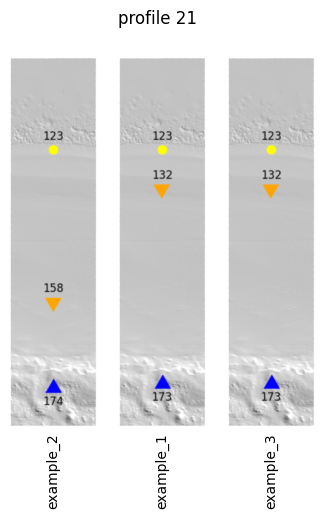

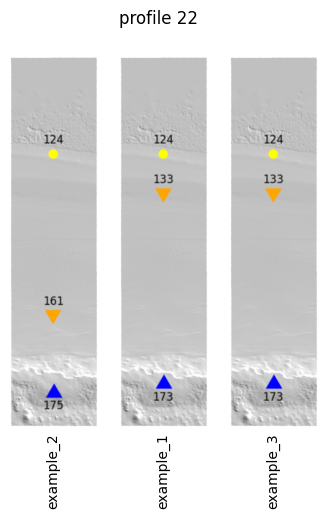

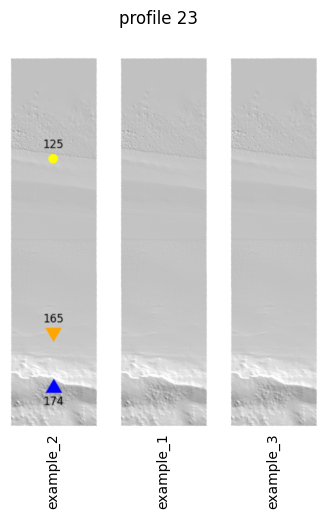

In [151]:
samples_no = len(samples)
px = 1/plt.rcParams['figure.dpi']
plt.ioff()

for profile_id in profiles_to_compare:
    im = plt.imread(os.path.join(sample['path'], TMP_FOLDER, f'{profile_id}.png'))
    height, width, na = im.shape
    
    fig, axs = plt.subplots(1, samples_no)
    px = 1/plt.rcParams['figure.dpi']
    fig.figure.set_figwidth(width*samples_no*px)
    fig.suptitle(f'profile {profile_id}')
    for idx, sample in enumerate(samples):
        im = plt.imread(os.path.join(sample['path'], TMP_FOLDER, f'{profile_id}.png'))
        axs[idx].set_xlabel(os.path.basename(sample['path']), rotation=90)
        axs[idx].imshow(im)
        axs[idx].get_xaxis().set_ticks([])
        axs[idx].spines[:].set_visible(False)
        axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].yaxis.set_tick_params(labelleft=False)
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
    file_name = os.path.join(OUTPUT_FIGURES_FOLDER, f'{profile_id}.svg')
    plt.savefig(file_name, dpi=300, transparent=True)
    if DEBUG:
        plt.show()
    plt.close()
    

In [152]:
for sample_id, sample in enumerate(samples):
    tmp_folder = os.path.join(sample['path'], TMP_FOLDER)
    clean_folder(tmp_folder)
    os.rmdir(tmp_folder)